In [492]:
pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [493]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import SimpleExpSmoothing , ExponentialSmoothing

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf

from sklearn.metrics import mean_squared_error

import statsmodels.api as sm

import warnings 
warnings.filterwarnings('ignore')

In [494]:
store_df = pd.read_excel('DS3_C6_S4_TimeSeries_Sales_Data_Project.xls' , index_col = 'Order Date' , parse_dates = ['Order Date'] )
store_df.sort_index(inplace = True)

In [495]:
store_df['Category'].value_counts()

Office Supplies    6026
Furniture          2121
Technology         1847
Name: Category, dtype: int64

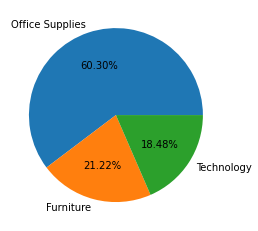

In [496]:
plt.pie(store_df['Category'].value_counts() , labels = store_df['Category'].value_counts().keys() , autopct = '%0.2f%%');

<AxesSubplot: xlabel='Category', ylabel='Sales'>

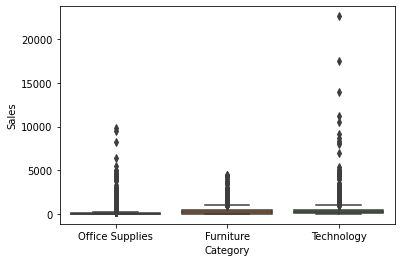

In [497]:
sns.boxplot(x=store_df['Category'] , y= store_df['Sales'])

In [498]:
numeric = store_df.select_dtypes(exclude = 'object')
numeric.drop(columns = 'Ship Date' , inplace = True)

<AxesSubplot: xlabel='variable', ylabel='value'>

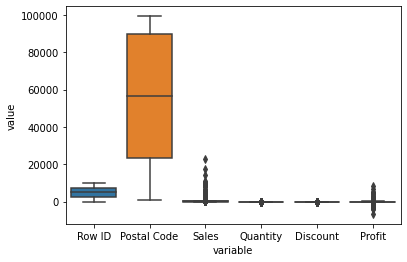

In [499]:
sns.boxplot(x='variable' , y= 'value' , data = pd.melt(numeric))

In [500]:
store_df['Years'] = [i.year for i in store_df.index]
store_df['Month'] = [i.strftime('%m') for i in store_df.index]
store_df['Week'] = [i.day_name() for i in store_df.index]


<AxesSubplot: xlabel='Week', ylabel='Sales'>

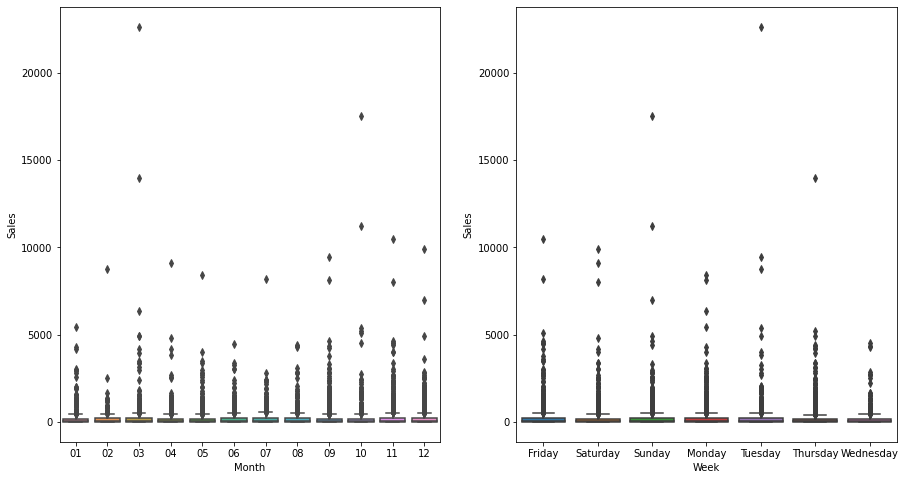

In [501]:
fig , ax = plt.subplots(1,2,figsize= (15,8))

sns.boxplot(x=store_df['Month'] , y = store_df['Sales'] , ax=ax[0])

sns.boxplot(x=store_df['Week'] , y = store_df['Sales'] , ax=ax[1])


In [502]:
store_df[store_df['Category']=='Furniture'][['Sales']]

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,545.940
...,...
2017-12-29,300.980
2017-12-29,68.460
2017-12-29,393.568


<AxesSubplot: xlabel='Month', ylabel='Sales'>

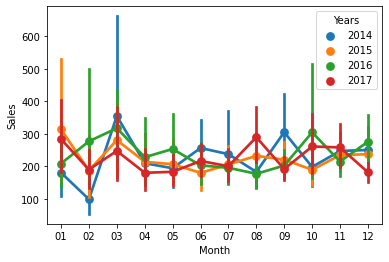

In [503]:
sns.pointplot(x=store_df['Month'] , y = store_df['Sales']  , hue = store_df['Years'])

## Furniture Monthly Sales

In [504]:
Fur_M = store_df[store_df['Category']=='Furniture']['Sales'].resample('M').sum().asfreq('M')
Fur_M

Order Date
2014-01-31     6242.5250
2014-02-28     1839.6580
2014-03-31    14573.9560
2014-04-30     7944.8370
2014-05-31     6912.7870
2014-06-30    13206.1256
2014-07-31    10821.0510
2014-08-31     7320.3465
2014-09-30    23816.4808
2014-10-31    12304.2470
2014-11-30    21564.8727
2014-12-31    30645.9665
2015-01-31    11739.9416
2015-02-28     3134.3740
2015-03-31    12499.7830
2015-04-30    10475.6985
2015-05-31     9374.9505
2015-06-30     7714.1790
2015-07-31    13674.4200
2015-08-31     9638.5922
2015-09-30    26273.0230
2015-10-31    12026.6235
2015-11-30    30880.8325
2015-12-31    23085.8192
2016-01-31     7622.7430
2016-02-29     3925.5510
2016-03-31    12801.0920
2016-04-30    13212.0900
2016-05-31    15119.8350
2016-06-30    13070.5720
2016-07-31    13068.5190
2016-08-31    12483.2323
2016-09-30    27262.8809
2016-10-31    11872.5770
2016-11-30    31783.6288
2016-12-31    36678.7150
2017-01-31     5964.0320
2017-02-28     6866.3374
2017-03-31    10893.4448
2017-04-30    

In [505]:
print('Start Date',Fur_M.index.min())
print('End Date',Fur_M.index.max())

Start Date 2014-01-31 00:00:00
End Date 2017-12-31 00:00:00


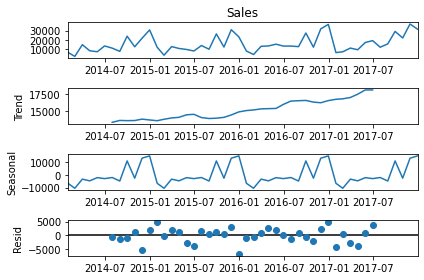

In [506]:
seasonal_decompose(Fur_M , period = 12).plot()
plt.tight_layout()

In [507]:
# decomposition  = seasonal_decompose(Fur_M , period = 12)
# d_trend = decomposition.trend
# d_seasonal = decomposition.seasonal
# d_residual = decomposition.resid

In [508]:
# detrended = Fur_M - d_trend
# d_trend.dropna(inplace = True)

# deseasonalized = detrended / d_seasonal
# deseasonalized.dropna(inplace = True)

In [509]:
# seasonal_decompose(deseasonalized , period = 12).plot()
# plt.tight_layout()

In [510]:
def checkstationary(data):
    pvalue = adfuller(data)[1]
    print(pvalue)

    if pvalue < 0.05:
        global msg
        msg = 'Data is Stationary proceed to model building'
    

    else:
        msg = 'Data is not stationary , make stationary before making a model'

    return msg

In [511]:
checkstationary(Fur_M)

8.450793985809654e-05


'Data is Stationary proceed to model building'

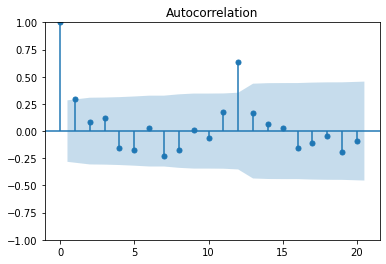

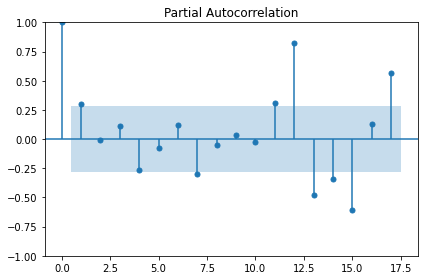

In [512]:
plot_acf(Fur_M , lags = 20)

plot_pacf(Fur_M , lags = 17)

plt.tight_layout()

p = 9

q = 2

d = 0

## Building Model for stationary Data (Furnitures)

### 1. Make AR model

In [513]:
a = {}
for p in range(1,10):
  ar_1 = ARIMA(Fur_M , order = (p,0,0))
  r1 = ar_1.fit()
  a[f'Take p = {p} for AIC'] = r1.aic

for key , value in a.items():
  if value == min(a.values()):
    print(key , value)

Take p = 1 for AIC 1011.6311140541756


In [514]:
ar_1 = ARIMA(Fur_M , order = (1,0,0))
r1 = ar_1.fit()
print(r1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -502.816
Date:                Wed, 01 Feb 2023   AIC                           1011.631
Time:                        16:26:30   BIC                           1017.245
Sample:                    01-31-2014   HQIC                          1013.753
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.546e+04   1874.269      8.248      0.000    1.18e+04    1.91e+04
ar.L1          0.3176      0.131      2.417      0.016       0.060       0.575
sigma2      7.327e+07      0.114   6.44e+08      0.0

### 2. Make MA model

In [515]:
a = {}
for q in range(1,3):
  ar_2 = ARIMA(Fur_M , order = (0,0,q))
  r2 = ar_2.fit()
  a[f'Take p = {q} for AIC'] = r2.aic

for key , value in a.items():
  if value == min(a.values()):
    print(key , value)

Take p = 1 for AIC 1011.8330449989652


In [516]:
ar_2 = ARIMA(Fur_M , order = (0,0,1))
r2 = ar_2.fit()
print(r2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -502.917
Date:                Wed, 01 Feb 2023   AIC                           1011.833
Time:                        16:26:31   BIC                           1017.447
Sample:                    01-31-2014   HQIC                          1013.954
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.546e+04   1649.302      9.373      0.000    1.22e+04    1.87e+04
ma.L1          0.3148      0.122      2.586      0.010       0.076       0.553
sigma2      7.486e+07      0.099   7.53e+08      0.0

### 3. Make ARMA Model

In [517]:
# a = {}
# d = 0
# for p in range(1,3):
#     for q in range(1,3):
#         ar_m3 = ARIMA(Fur_M , order = (p,d,q))
#         r3 = ar_m3.fit()
#         print(f'AIC for p = {p} and q = {q} is {r3.aic}')
#         a[f'Take AIC for p = {p} and q = {q} is'] = r3.aic
        
# for key , values in a.items():
#     if values == min(a.values()):
#         print(key , values)

In [518]:
ar_m3 = ARIMA(Fur_M , order = (1,0,1))
r3 = ar_m3.fit()
print(r3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -502.775
Date:                Wed, 01 Feb 2023   AIC                           1013.551
Time:                        16:26:31   BIC                           1021.035
Sample:                    01-31-2014   HQIC                          1016.379
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.546e+04   2190.507      7.057      0.000    1.12e+04    1.98e+04
ar.L1          0.4685      0.452      1.036      0.300      -0.418       1.355
ma.L1         -0.1624      0.492     -0.330      0.7

## Lesser the AIC score is better the model. Since less information is lost. Hence ARMA(1,0,1) is better model

In [519]:
0.8*len(Fur_M)

38.400000000000006

In [520]:
train = Fur_M[:38].copy()
test = Fur_M[38:].copy()

In [521]:
ar_m4 = ARIMA(train , order = (9,0,2))
r4 = ar_m4.fit()

In [522]:
pvalue = sm.stats.acorr_ljungbox(r4.resid , lags = [1] , return_df = True)['lb_pvalue'].values
print(pvalue)

if pvalue < 0.05:
  print('Bad Model')

else:
  print('Good Model')

[0.86858786]
Good Model


In [523]:
predictions = r4.predict(0,len(test)-1)
predictions

Order Date
2014-01-31    14195.873811
2014-02-28    13080.048668
2014-03-31    12764.673603
2014-04-30    13825.012264
2014-05-31    12452.306304
2014-06-30    18216.330417
2014-07-31    16522.593824
2014-08-31    16646.176111
2014-09-30    20775.710589
2014-10-31    20812.810628
Freq: M, Name: predicted_mean, dtype: float64

In [524]:
actual = [] ; pred = []

for i in range(len(predictions)):
  actual.append(test[i])
  pred.append(predictions[i])

df_res = pd.DataFrame({'Actual' : actual , 'Predictions' : pred})
df_res['Error'] = df_res['Actual'] - df_res['Predictions']
print(df_res)

       Actual   Predictions         Error
0  10893.4448  14195.873811  -3302.429011
1   9065.9581  13080.048668  -4014.090568
2  16957.5582  12764.673603   4192.884597
3  19008.5867  13825.012264   5183.574436
4  11813.0220  12452.306304   -639.284304
5  15441.8740  18216.330417  -2774.456417
6  29028.2060  16522.593824  12505.612176
7  21884.0682  16646.176111   5237.892089
8  37056.7150  20775.710589  16281.004411
9  31407.4668  20812.810628  10594.656172


<AxesSubplot: >

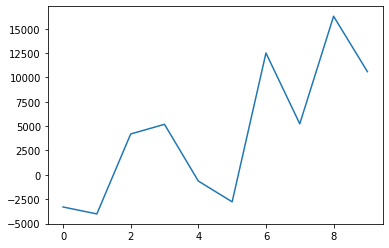

In [525]:
df_res['Error'].plot()

In [526]:
msg = 'ARIMA Model. Order = (9,0,2)'
mse = mean_squared_error(df_res['Actual'] , df_res['Predictions'])
print(f'{msg}\n\tMSE is : {mse}\n\tRMSE is : {np.sqrt(mse)}')

ARIMA Model. Order = (9,0,2)
	MSE is : 64071867.19559501
	RMSE is : 8004.490439471772


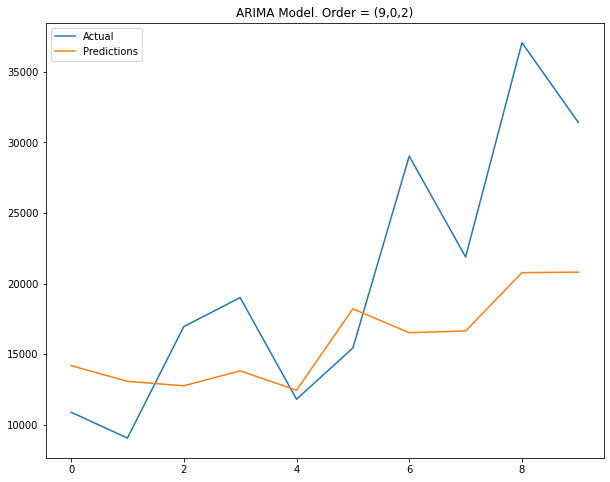

In [527]:
df_res['Actual'].plot(figsize=(10,8) , legend = True)
df_res['Predictions'].plot(legend = True)
plt.title(msg);

In [528]:
forecasting_Fur_M = r4.forecast(24)

In [529]:
initial_Fur_M = pd.concat([train , forecasting_Fur_M[0:1]] , axis = 0)

<AxesSubplot: >

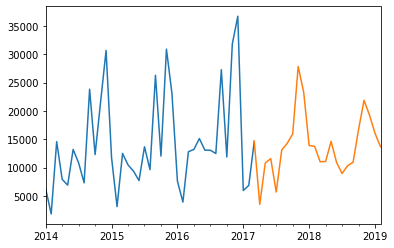

In [530]:
initial_Fur_M.plot()
forecasting_Fur_M.plot()

## Office Supplies Monthly Sales

In [531]:
OF_M = store_df[store_df['Category']=='Office Supplies']['Sales'].resample('M').sum().asfreq('M')
OF_M

Order Date
2014-01-31     4851.080
2014-02-28     1071.724
2014-03-31     8605.879
2014-04-30    11155.074
2014-05-31     7135.624
2014-06-30    12953.037
2014-07-31    15121.208
2014-08-31    11379.462
2014-09-30    27423.298
2014-10-31     7211.128
2014-11-30    26862.436
2014-12-31    18006.462
2015-01-31     1808.780
2015-02-28     5368.067
2015-03-31    15882.547
2015-04-30    12558.558
2015-05-31     9113.736
2015-06-30    10647.747
2015-07-31     4719.939
2015-08-31    11735.108
2015-09-30    19305.767
2015-10-31     8673.410
2015-11-30    21218.130
2015-12-31    16201.674
2016-01-31     5299.682
2016-02-29     6794.350
2016-03-31    17346.931
2016-04-30    10647.447
2016-05-31    13035.202
2016-06-30    10901.810
2016-07-31    12924.444
2016-08-31     8959.740
2016-09-30    23263.738
2016-10-31    16281.794
2016-11-30    20487.278
2016-12-31    37997.566
2017-01-31    21274.289
2017-02-28     7407.772
2017-03-31    14550.286
2017-04-30    15072.191
2017-05-31    13736.964
2017-

In [532]:
print('Start Date',OF_M.index.min())
print('End Date',OF_M.index.max())

Start Date 2014-01-31 00:00:00
End Date 2017-12-31 00:00:00


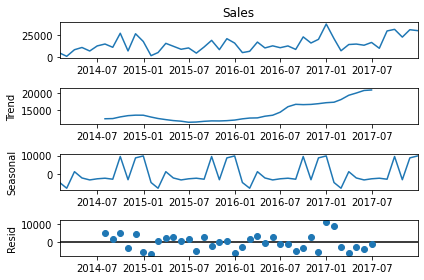

In [533]:
seasonal_decompose(OF_M , period = 12).plot()
plt.tight_layout()

In [534]:
checkstationary(OF_M)

0.329487275494728


'Data is not stationary , make stationary before making a model'

In [535]:
check_for_shift = OF_M.copy()

In [536]:
for i in range(1,25):
    check_for_shift = check_for_shift - check_for_shift.shift(i)
    check_for_shift.dropna(inplace = True)
    checkstationary(check_for_shift)
    if msg == 'Data is Stationary proceed to model building' :
        print(f'Data is Stationary at shift {i}')
        break

0.0004287262459097803
Data is Stationary at shift 1


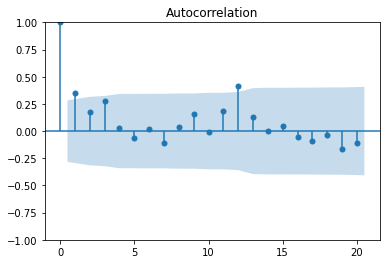

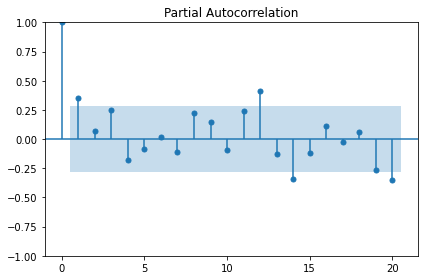

In [537]:
plot_acf(OF_M , lags = 20)

plot_pacf(OF_M , lags = 20)

plt.tight_layout()

p = 4

q = 2

d = 1

## Building Model for Non stationary Data (Office Supplies)

### 1. Make AR model

In [538]:
a = {}
for p in range(1,5):
  ar_5 = ARIMA(OF_M , order = (p,1,0))
  r5 = ar_5.fit()
  a[f'Take p = {p} for AIC'] = r5.aic

for key , value in a.items():
  if value == min(a.values()):
    print(key , value)

Take p = 2 for AIC 981.5067421675725


In [539]:
ar_6 = ARIMA(OF_M , order = (2,1,0))
r6 = ar_6.fit()
print(r6.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -487.753
Date:                Wed, 01 Feb 2023   AIC                            981.507
Time:                        16:26:38   BIC                            987.057
Sample:                    01-31-2014   HQIC                           983.595
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5856      0.134     -4.363      0.000      -0.849      -0.323
ar.L2         -0.4080      0.145     -2.822      0.005      -0.691      -0.125
sigma2      6.163e+07   5.71e-10   1.08e+17      0.0

### 2. Make MA model

In [540]:
a = {}
for q in range(1,3):
  ar_7 = ARIMA(Fur_M , order = (0,1,q))
  r7 = ar_7.fit()
  a[f'Take q = {q} for AIC'] = r7.aic

for key , value in a.items():
  if value == min(a.values()):
    print(key , value)

Take q = 1 for AIC 994.2446376693218


In [541]:
ar_7 = ARIMA(OF_M , order = (0,1,1))
r7 = ar_7.fit()
print(r7.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -488.681
Date:                Wed, 01 Feb 2023   AIC                            981.363
Time:                        16:26:38   BIC                            985.063
Sample:                    01-31-2014   HQIC                           982.755
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6803      0.127     -5.358      0.000      -0.929      -0.431
sigma2      7.152e+07   3.67e-11   1.95e+18      0.000    7.15e+07    7.15e+07
Ljung-Box (L1) (Q):                   0.00   Jarque-

### MAKE ARIMA

In [542]:
a = {}
d = 1
for q in range(1,2):
    for p in range(1,3):
        ar_m8 = ARIMA(Fur_M , order = (p,d,q))
        r8 = ar_m8.fit()
        print(f'AIC for p = {p} and q = {q} is {r8.aic}')
        a[f'Take AIC for p = {p} and q = {q} is'] = r8.aic
        
for key , values in a.items():
    if values == min(a.values()):
        print(key , values)

AIC for p = 1 and q = 1 is 994.7447798905712
AIC for p = 2 and q = 1 is 998.3130305829308
Take AIC for p = 1 and q = 1 is 994.7447798905712


In [543]:
0.8*len(OF_M)

38.400000000000006

In [544]:
train = OF_M[:38].copy()
test = OF_M[38:].copy()

In [545]:
ar_m8 = ARIMA(Fur_M , order = (4,1,2))
r8 = ar_m8.fit()

In [546]:
pvalue = sm.stats.acorr_ljungbox(r8.resid , lags = [1] , return_df = True)['lb_pvalue'].values
print(pvalue)

if pvalue < 0.05:
  print('Bad Model')

else:
  print('Good Model')

[0.69816485]
Good Model


In [547]:
predictions = r8.predict(0,len(test)-1)
predictions

Order Date
2014-01-31        0.000000
2014-02-28     3963.382580
2014-03-31     2150.246709
2014-04-30     9878.701267
2014-05-31     6608.258771
2014-06-30     8076.330253
2014-07-31     7789.168818
2014-08-31     7277.786196
2014-09-30     7092.278895
2014-10-31    11563.783881
Freq: M, Name: predicted_mean, dtype: float64

In [548]:
actual = [] ; pred = []

for i in range(len(predictions)):
  actual.append(test[i])
  pred.append(predictions[i])

df_res = pd.DataFrame({'Actual' : actual , 'Predictions' : pred})
df_res['Error'] = df_res['Actual'] - df_res['Predictions']
print(df_res)

      Actual   Predictions         Error
0  14550.286      0.000000  14550.286000
1  15072.191   3963.382580  11108.808420
2  13736.964   2150.246709  11586.717291
3  16912.039   9878.701267   7033.337733
4  10241.468   6608.258771   3633.209229
5  30059.852   8076.330253  21983.521747
6  31895.843   7789.168818  24106.674182
7  23037.192   7277.786196  15759.405804
8  31472.337   7092.278895  24380.058105
9  30436.942  11563.783881  18873.158119


<AxesSubplot: >

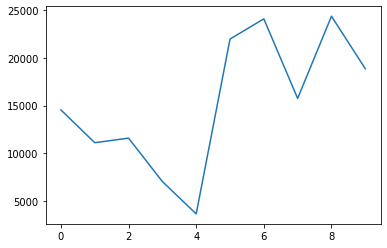

In [549]:
df_res['Error'].plot()

In [550]:
msg = 'ARIMA Model. Order = (4,1,2)'
mse = mean_squared_error(df_res['Actual'] , df_res['Predictions'])
print(f'{msg}\n\tMSE is : {mse}\n\tRMSE is : {np.sqrt(mse)}')

ARIMA Model. Order = (4,1,2)
	MSE is : 279538568.4154454
	RMSE is : 16719.40693970469


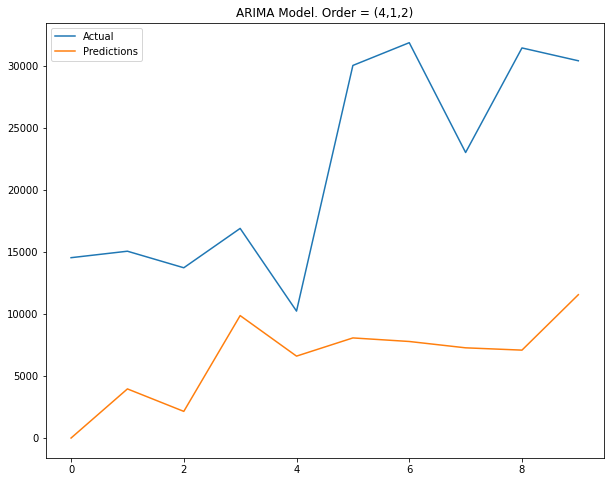

In [551]:
df_res['Actual'].plot(figsize=(10,8) , legend = True)
df_res['Predictions'].plot(legend = True)
plt.title(msg);

In [552]:
forecasting = r8.forecast(24)

In [553]:
initial = pd.concat([train , forecasting[0:1]] , axis = 0)

<AxesSubplot: >

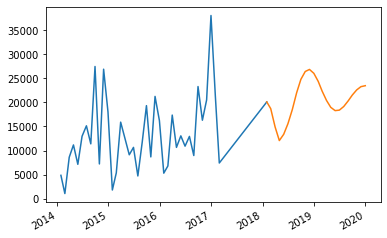

In [554]:
initial.plot()
forecasting.plot()

### MAKE SARIMA

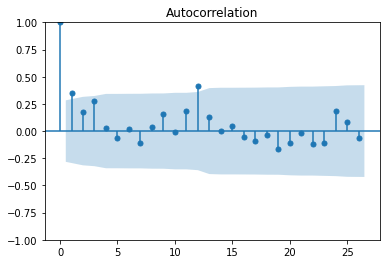

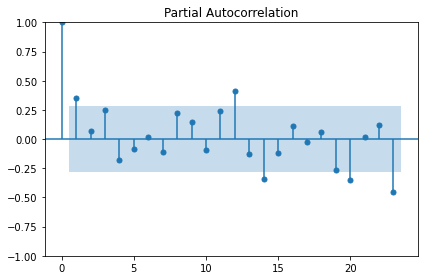

In [555]:
plot_acf(OF_M , lags = 26)

plot_pacf(OF_M , lags = 23)

plt.tight_layout()

Seasonal components:

P = 3

m = 12

Q = 2

In [556]:
a = {}
D = 1
for Q in range(1,2):
    for P in range(1,3):
        ar_m9 = sm.tsa.statespace.SARIMAX(OF_M , order = (4,1,2) , seasonal_order = (P,D,Q,12))
        r9 = ar_m9.fit()
        print(f'AIC for p = {P} and q = {Q} is {r9.aic}')
        a[f'Take AIC for p = {P} and q = {Q} is'] = r9.aic
        
for key , values in a.items():
    if values == min(a.values()):
        print(key , values)

AIC for p = 1 and q = 1 is 729.729616024242
AIC for p = 2 and q = 1 is 731.747032843259
Take AIC for p = 1 and q = 1 is 729.729616024242


In [557]:
final = sm.tsa.statespace.SARIMAX(train , order = (4,1,2) , seasonal_order = (1,1,1,12)).fit()
final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Sales   No. Observations:                   38
Model:             SARIMAX(4, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -252.123
Date:                              Wed, 01 Feb 2023   AIC                            522.247
Time:                                      16:26:48   BIC                            533.217
Sample:                                  01-31-2014   HQIC                           525.289
                                       - 02-28-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7005      0.791     -0.886      0.376      -2.250       0.849
ar.L2         -1.4155      0.666     -2.126      0.034      -2.721      -0.110
ar.L3         -0.5598      0.454     -1.232      0.218      -1.450       0.331
ar.L4         -0.4523      0.320     -1.414      0.157      -1.079       0.175
ma.L1          0.1554      0.753      0.206      0.837      -1.321       1.632
ma.L2          0.9685      0.508      1.906      0.057      -0.027       1.964
ar.S.L12      -0.0044      0.848     -0.005      0.996      -1.666       1.657
ma.S.L12      -0.4798      1.263     -0.380      0.704      -2.955       1.995
sigma2      4.033e+07   2.62e-08   1.54e+15      0.000    4.03e+07    4.03e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):                 8.40
Prob(Q):                              0.31   Prob(JB):                         0.01
Heteroskedasticity (H):               3.50   Skew:                             1.01
Prob(H) (two-sided):                  0.10   Kurtosis:                         5.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.42e+31. Standard errors may be unstable.
"""

In [558]:
pvalue = sm.stats.acorr_ljungbox(final.resid , lags = [1] , return_df = True)['lb_pvalue'].values
print(pvalue)
if pvalue < 0.05:
    print('Reject H0 . Bad Model')
    
else:
    print('Failed to reject H0. Hence the selected model is good')

[0.21219171]
Failed to reject H0. Hence the selected model is good


In [559]:
predictions = final.predict(0,len(test)-1)
print(predictions)

Order Date
2014-01-31        0.000000
2014-02-28     2979.677256
2014-03-31     1181.939197
2014-04-30     6246.715073
2014-05-31     6329.890000
2014-06-30     8480.161389
2014-07-31    11244.079378
2014-08-31    11483.040261
2014-09-30    13025.477858
2014-10-31    19738.281336
Freq: M, Name: predicted_mean, dtype: float64


In [560]:
actual = [] ; pred = []

for i in range(len(predictions)):
    actual.append(test[i])
    pred.append(predictions[i])

df_res = pd.DataFrame({'Actual' : actual , 'Predictions' : pred})
df_res['error'] = df_res['Actual'] - df_res['Predictions']

print(df_res)

      Actual   Predictions         error
0  14550.286      0.000000  14550.286000
1  15072.191   2979.677256  12092.513744
2  13736.964   1181.939197  12555.024803
3  16912.039   6246.715073  10665.323927
4  10241.468   6329.890000   3911.578000
5  30059.852   8480.161389  21579.690611
6  31895.843  11244.079378  20651.763622
7  23037.192  11483.040261  11554.151739
8  31472.337  13025.477858  18446.859142
9  30436.942  19738.281336  10698.660664


<AxesSubplot: >

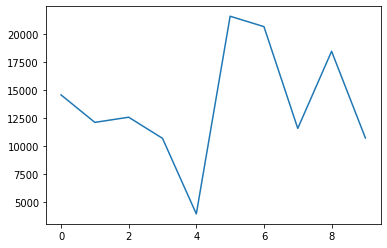

In [561]:
df_res['error'].plot()

In [562]:
msg = 'SARIMA Model. Order = (4,1,2)*(1,1,1)[12]'
mse = mean_squared_error(df_res['Actual'] , df_res['Predictions'])

print(f'{msg}\n\tMSE is : {mse}\n\tRMSE is : {np.sqrt(mse)}')

SARIMA Model. Order = (4,1,2)*(1,1,1)[12]
	MSE is : 212504269.82760733
	RMSE is : 14577.526190256265


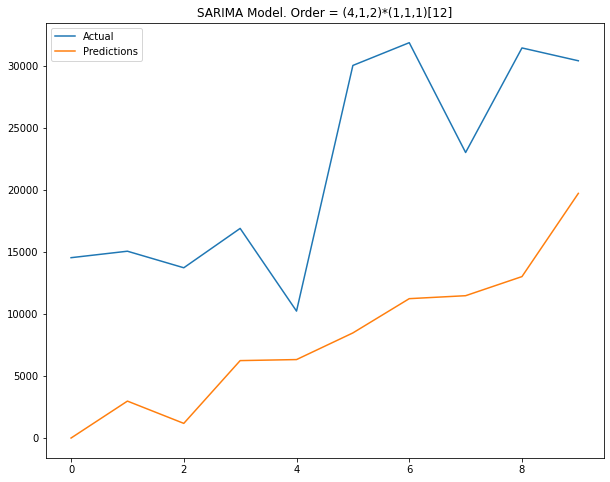

In [563]:
df_res['Actual'].plot(figsize=(10,8) , legend = True)
df_res['Predictions'].plot(legend = True)
plt.title(msg);

In [564]:
forecasting_OF_M = final.forecast(24)

In [565]:
initial_OF_M = pd.concat([train , forecasting_OF_M[0:1]] , axis = 0)

<AxesSubplot: >

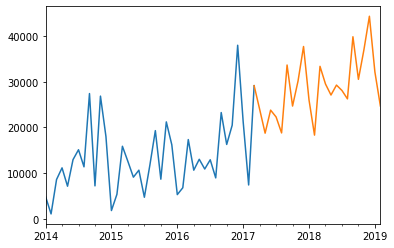

In [566]:
initial_OF_M.plot()
forecasting_OF_M.plot()

## Technology Monthly Sales

In [567]:
Tec_M = store_df[store_df['Category']=='Technology']['Sales'].resample('M').sum().asfreq('M')
Tec_M

Order Date
2014-01-31     3143.290
2014-02-28     1608.510
2014-03-31    32511.174
2014-04-30     9195.434
2014-05-31     9599.876
2014-06-30     8435.965
2014-07-31     8004.134
2014-08-31     9209.660
2014-09-30    30537.572
2014-10-31    11938.018
2014-11-30    30201.408
2014-12-31    20893.192
2015-01-31     4625.354
2015-02-28     3448.970
2015-03-31    10343.922
2015-04-30    11160.952
2015-05-31    11643.000
2015-06-30     6435.366
2015-07-31    10370.966
2015-08-31    15524.632
2015-09-30    19017.128
2015-10-31    10704.890
2015-11-30    23873.601
2015-12-31    35632.028
2016-01-31     5620.066
2016-02-29    12258.914
2016-03-31    21567.852
2016-04-30    14890.502
2016-05-31    28832.691
2016-06-30    16372.152
2016-07-31    13269.000
2016-08-31     9672.402
2016-09-30    22883.406
2016-10-31    31533.374
2016-11-30    27141.059
2016-12-31    22322.762
2017-01-31    16733.053
2017-02-28     6027.024
2017-03-31    33428.622
2017-04-30    12383.387
2017-05-31    13566.588
2017-

In [568]:
print('Start Date',Tec_M.index.min())
print('End Date',Tec_M.index.max())

Start Date 2014-01-31 00:00:00
End Date 2017-12-31 00:00:00


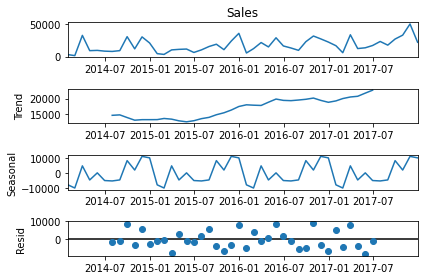

In [569]:
seasonal_decompose(Tec_M , period = 12).plot()
plt.tight_layout()

In [570]:
checkstationary(Tec_M)

1.8615967302063814e-06


'Data is Stationary proceed to model building'

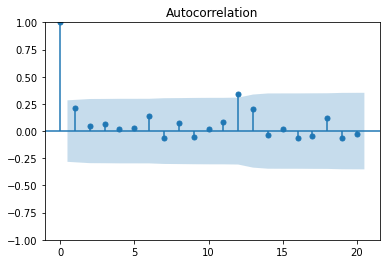

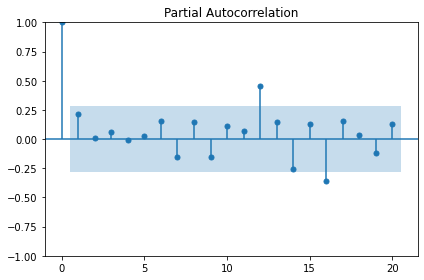

In [571]:
plot_acf(Tec_M , lags = 20)

plot_pacf(Tec_M , lags = 20)

plt.tight_layout()

p = 2

q = 1

## Building Model for stationary Data (Technology)

### 1. Make AR model

In [572]:
a = {}
for p in range(1,3):
  ar_10 = ARIMA(Tec_M , order = (p,0,0))
  r10 = ar_10.fit()
  a[f'Take p = {p} for AIC'] = r10.aic

for key , value in a.items():
  if value == min(a.values()):
    print(key , value)

Take p = 1 for AIC 1027.2425843437704


### 2. Make MA model

In [573]:
ar_11 = ARIMA(Tec_M , order = (0,0,1))
r11 = ar_11.fit()
print('Take q =',1,'for AIC ',r11.aic)

Take q = 1 for AIC  1027.5891968290612


### 3. MAKE ARAMA

In [574]:
ar_m12 = ARIMA(Tec_M , order = (1,0,1))
r12 = ar_m12.fit()

In [575]:
0.8*(len(Tec_M))

38.400000000000006

In [576]:
train = Tec_M[:38].copy()
test = Tec_M[38:].copy()

In [577]:
ar_m13 = ARIMA(train , order = (7,0,6))
r13 = ar_m13.fit()

In [578]:
pvalue = sm.stats.acorr_ljungbox(r13.resid , lags = [1] , return_df = True)['lb_pvalue'].values
print(pvalue)

if pvalue < 0.05:
  print('Bad Model')

else:
  print('Good Model')

[0.92702609]
Good Model


In [579]:
predictions = r13.predict(0,len(test)-1)
predictions

Order Date
2014-01-31    15452.192615
2014-02-28    14448.247387
2014-03-31    15246.833691
2014-04-30    17631.498948
2014-05-31    13724.311927
2014-06-30    18260.459482
2014-07-31    11441.550964
2014-08-31    14584.340489
2014-09-30    25155.891922
2014-10-31    12981.573039
Freq: M, Name: predicted_mean, dtype: float64

In [580]:
actual = [] ; pred = []

for i in range(len(predictions)):
  actual.append(test[i])
  pred.append(predictions[i])

df_res = pd.DataFrame({'Actual' : actual , 'Predictions' : pred})
df_res['Error'] = df_res['Actual'] - df_res['Predictions']
print(df_res)

      Actual   Predictions         Error
0  33428.622  15452.192615  17976.429385
1  12383.387  14448.247387  -2064.860387
2  13566.588  15246.833691  -1680.245691
3  17061.100  17631.498948   -570.398948
4  23209.926  13724.311927   9485.614073
5  17619.162  18260.459482   -641.297482
6  26942.603  11441.550964  15501.052036
7  32855.663  14584.340489  18271.322511
8  49918.773  25155.891922  24762.881078
9  21984.910  12981.573039   9003.336961


<AxesSubplot: >

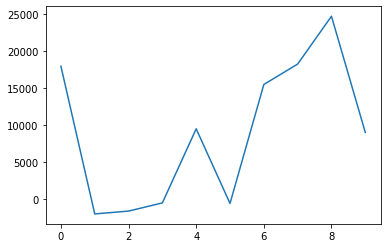

In [581]:
df_res['Error'].plot()

In [582]:
msg = 'ARIMA Model. Order = (7,0,6)'
mse = mean_squared_error(df_res['Actual'] , df_res['Predictions'])
print(f'{msg}\n\tMSE is : {mse}\n\tRMSE is : {np.sqrt(mse)}')

ARIMA Model. Order = (7,0,6)
	MSE is : 168933657.54500413
	RMSE is : 12997.448116649826


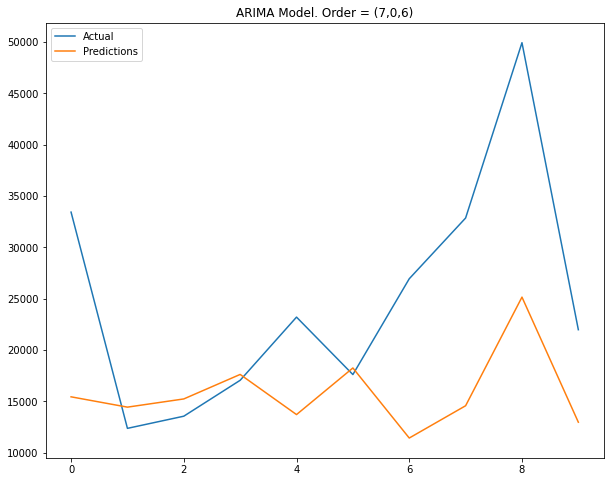

In [583]:
df_res['Actual'].plot(figsize=(10,8) , legend = True)
df_res['Predictions'].plot(legend = True)
plt.title(msg);

In [584]:
forecasting_Tec_M = r13.forecast(24)

In [585]:
initial_Tec_M = pd.concat([train , forecasting_Tec_M[0:1]] , axis = 0)

<AxesSubplot: >

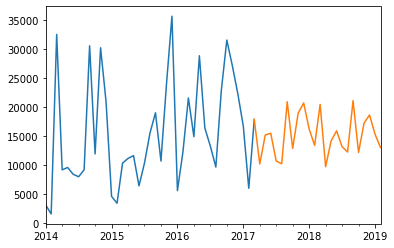

In [586]:
initial_Tec_M.plot()
forecasting_Tec_M.plot()

In [587]:
AIC = []
MSE = []
RMSE = []
Status = []
index = []
for p in range(1,8):
  for q in range(1,8):

    ar_m13 = ARIMA(train , order = (p,0,q))
    r13 = ar_m13.fit()
    
    index.append((p,0,q))
    AIC.append(r13.aic)

    pvalue = sm.stats.acorr_ljungbox(r13.resid , lags = [1] , return_df = True)['lb_pvalue'].values
    #print(pvalue)

    if pvalue < 0.05:
      #print('Bad Model')
      Status.append('Bad Model')
    else:
      #print('Good Model')
      Status.append('Good Model')

    predictions = r13.predict(0,len(test)-1)

    actual = [] ; pred = []

    for i in range(len(predictions)):
      actual.append(test[i])
      pred.append(predictions[i])

    df_res = pd.DataFrame({'Actual' : actual , 'Predictions' : pred})
    #df_res['Error'] = df_res['Actual'] - df_res['Predictions']

    mse = mean_squared_error(df_res['Actual'] , df_res['Predictions'])
    MSE.append(mse)

    RMSE.append(np.sqrt(mse))



In [588]:
df = pd.DataFrame({'Index' : index , 'AIC' : AIC , 'MSE' : MSE , 'RMSE' : RMSE , 'Status' : Status})

In [589]:
df.sort_values(by = ['RMSE'],ascending = True)

,Index,AIC,MSE,RMSE,Status
41,"(6, 0, 7)",856.024982,1.662389e+08,12893.365573,Good Model
47,"(7, 0, 6)",822.847043,1.689337e+08,12997.448117,Good Model
34,"(5, 0, 7)",844.845039,1.704331e+08,13055.001350,Good Model
46,"(7, 0, 5)",822.306039,1.739153e+08,13187.696522,Good Model
48,"(7, 0, 7)",870.118911,1.769491e+08,13302.220355,Good Model
45,"(7, 0, 4)",818.798181,1.854107e+08,13616.560535,Good Model
40,"(6, 0, 6)",819.996355,1.887236e+08,13737.672591,Good Model
31,"(5, 0, 4)",814.503530,1.905031e+08,13802.284729,Good Model
27,"(4, 0, 7)",829.444399,1.920485e+08,13858.155677,Good Model
24,"(4, 0, 4)",816.854211,1.934130e+08,13907.300861,Good Model


In [590]:
df = pd.DataFrame({'Index' : index , 'AIC' : AIC , 'MSE' : MSE , 'RMSE' : RMSE , 'Status' : Status})

In [591]:
from tabulate import tabulate

print('%50s'%'**Furniture Sale**\n\n',tabulate({'Model':['ARMA'] ,'Parameter': [902] ,'MSE' : [64071867.195] , 'RMSE' : [8004.49]}
               ,headers = ['Model','Parameter','MSE', 'RMSE' ] , tablefmt = 'grid'))

                              **Furniture Sale**

 +---------+-------------+-------------+---------+
| Model   |   Parameter |         MSE |    RMSE |
+=========+=============+=============+=========+
| ARMA    |         902 | 6.40719e+07 | 8004.49 |
+---------+-------------+-------------+---------+


In [592]:
print('%50s'%'**Office Supplies Sale**\n\n',tabulate({'Model':['ARIMA','SARIMA'] ,'Parameter': ['4,1,2' , '(4,1,2)(1,1,1)[12]'] ,'MSE' : [279538568.41 , 212504269.82] , 'RMSE' : [16719.40 , 14577.52]}
               ,headers = ['Model','Parameter','MSE', 'RMSE' ] , tablefmt = 'grid'))

                        **Office Supplies Sale**

 +---------+--------------------+-------------+---------+
| Model   | Parameter          |         MSE |    RMSE |
+=========+====================+=============+=========+
| ARIMA   | 4,1,2              | 2.79539e+08 | 16719.4 |
+---------+--------------------+-------------+---------+
| SARIMA  | (4,1,2)(1,1,1)[12] | 2.12504e+08 | 14577.5 |
+---------+--------------------+-------------+---------+


In [593]:
print('%50s'%'**Technology Sale**\n\n',tabulate({'Model':['ARMA'] ,'Parameter': ['7,0,6'] ,'MSE' : [168933657.54] , 'RMSE' : [12997.44]}
               ,headers = ['Model','Parameter','MSE', 'RMSE' ] , tablefmt = 'grid'))

                             **Technology Sale**

 +---------+-------------+-------------+---------+
| Model   | Parameter   |         MSE |    RMSE |
+=========+=============+=============+=========+
| ARMA    | 7,0,6       | 1.68934e+08 | 12997.4 |
+---------+-------------+-------------+---------+


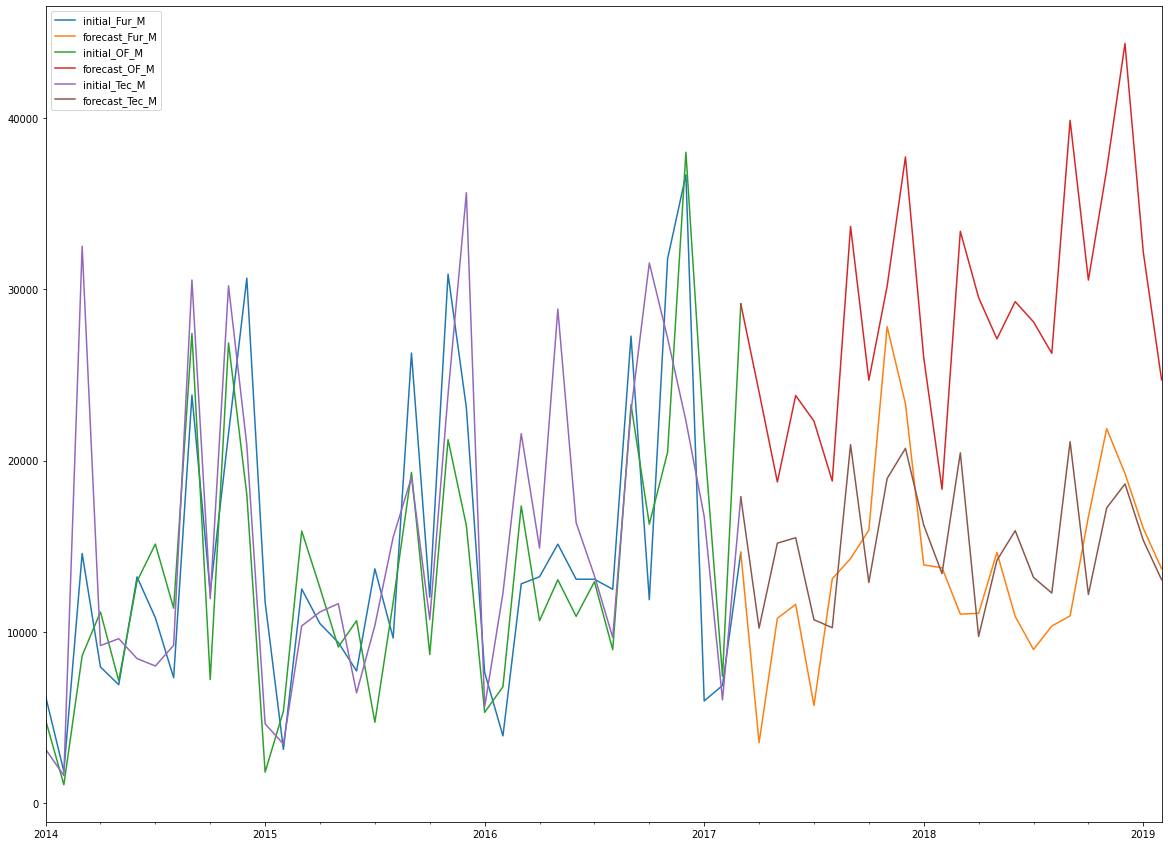

In [594]:
plt.figure(figsize=(20,15))
initial_Fur_M.plot(label = 'initial_Fur_M')
forecasting_Fur_M.plot(label = 'forecast_Fur_M')

initial_OF_M.plot(label = 'initial_OF_M')
forecasting_OF_M.plot(label ='forecast_OF_M')

initial_Tec_M.plot(label = 'initial_Tec_M')
forecasting_Tec_M.plot(label = 'forecast_Tec_M')

plt.legend()

<AxesSubplot: >

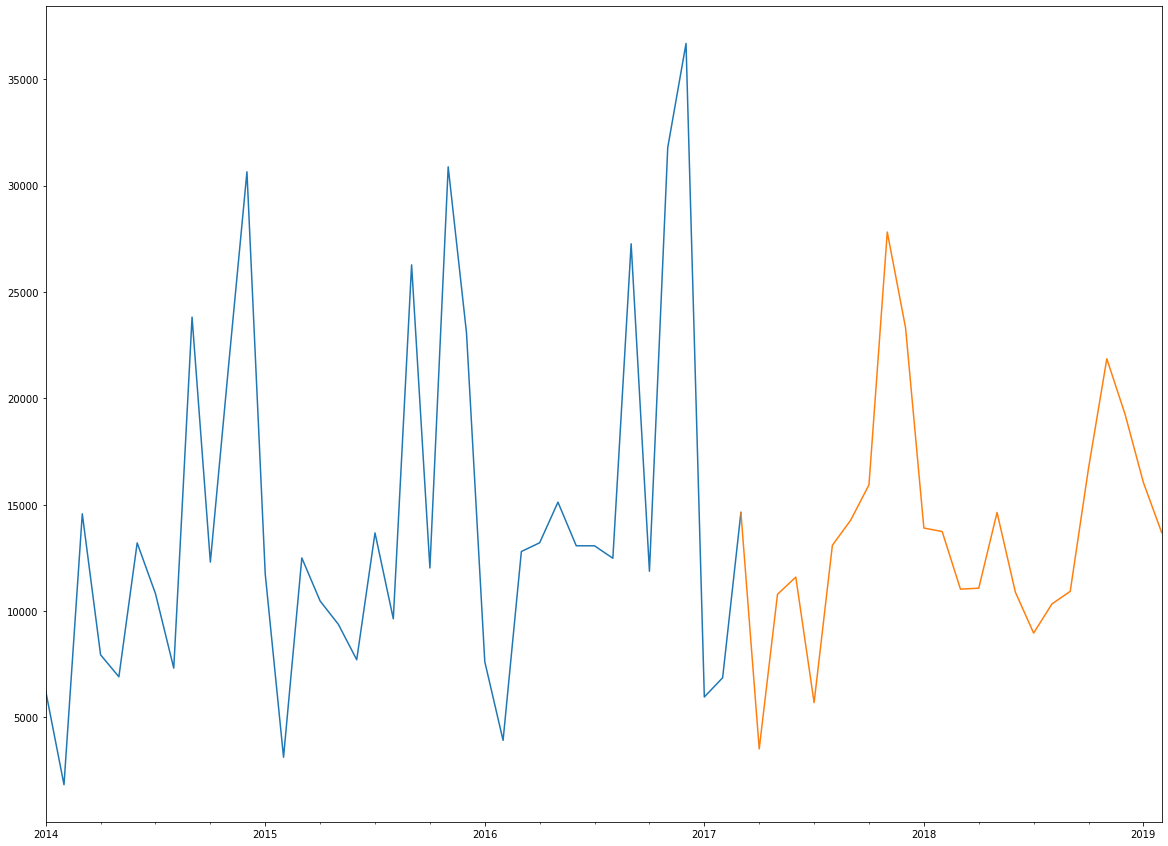

In [595]:
plt.figure(figsize=(20,15))
initial_Fur_M.plot(label = 'initial_Fur_M')
forecasting_Fur_M.plot(label = 'forecast_Fur_M')

# Interpretation

- Furniture Sales and Technology Sales is getting decreased over the period of time.

- Office Supplies Sales is increased over the periods of time

In [596]:
!pip install sweetviz

In [597]:
import sweetviz as sv
sweet_report = sv.analyze(pd.read_excel("DS3_C6_S4_TimeSeries_Sales_Data_Project.xls"))
sweet_report.show_html("sweet_report.html")

In [598]:
sweet_report

In [673]:
store_df.reset_index(inplace = True)

In [684]:
store_df

,index,Order Date,Row ID,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,...,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Years,Month,Week
0,0,2014-01-03,7981,CA-2014-103800,2014-01-07,Standard Class,DP-13000,Darren Powers,Consumer,United States,...,Office Supplies,Paper,"Message Book, Wirebound, Four 5 1/2"" X 4"" Form...",16.448,2,0.2,5.5512,2014,01,Friday
1,1,2014-01-04,740,CA-2014-112326,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,...,Office Supplies,Labels,Avery 508,11.784,3,0.2,4.2717,2014,01,Saturday
2,2,2014-01-04,741,CA-2014-112326,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,...,Office Supplies,Storage,SAFCO Boltless Steel Shelving,272.736,3,0.2,-64.7748,2014,01,Saturday
3,3,2014-01-04,742,CA-2014-112326,2014-01-08,Standard Class,PO-19195,Phillina Ober,Home Office,United States,...,Office Supplies,Binders,GBC Standard Plastic Binding Systems Combs,3.540,2,0.8,-5.4870,2014,01,Saturday
4,4,2014-01-05,1760,CA-2014-141817,2014-01-12,Standard Class,MB-18085,Mick Brown,Consumer,United States,...,Office Supplies,Art,Avery Hi-Liter EverBold Pen Style Fluorescent ...,19.536,3,0.2,4.8840,2014,01,Sunday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,9989,2017-12-30,5092,CA-2017-156720,2018-01-03,Standard Class,JM-15580,Jill Matthias,Consumer,United States,...,Office Supplies,Fasteners,Bagged Rubber Bands,3.024,3,0.2,-0.6048,2017,12,Saturday
9990,9990,2017-12-30,909,CA-2017-143259,2018-01-03,Standard Class,PO-18865,Patrick O'Donnell,Consumer,United States,...,Office Supplies,Binders,Wilson Jones Legal Size Ring Binders,52.776,3,0.2,19.7910,2017,12,Saturday
9991,9991,2017-12-30,908,CA-2017-143259,2018-01-03,Standard Class,PO-18865,Patrick O'Donnell,Consumer,United States,...,Technology,Phones,Gear Head AU3700S Headset,90.930,7,0.0,2.7279,2017,12,Saturday
9992,9992,2017-12-30,1297,CA-2017-115427,2018-01-03,Standard Class,EB-13975,Erica Bern,Corporate,United States,...,Office Supplies,Binders,"Cardinal Slant-D Ring Binder, Heavy Gauge Vinyl",13.904,2,0.2,4.5188,2017,12,Saturday


In [685]:
FFur_M = store_df[store_df['Category'] == 'Furniture'][['Row ID','Order Date', 'Ship Date' ,'Ship Mode', 'Sales']]

In [686]:
FFur_M['Diff'] =  (FFur_M['Ship Date'] - FFur_M['Order Date']).dt.days
FFur_M

,Row ID,Order Date,Ship Date,Ship Mode,Sales,Diff
6,7475,2014-01-06,2014-01-10,Standard Class,2573.820,4
14,7661,2014-01-07,2014-01-12,Standard Class,76.728,5
18,867,2014-01-10,2014-01-15,Standard Class,51.940,5
20,717,2014-01-11,2014-01-14,First Class,9.940,3
28,2979,2014-01-13,2014-01-16,Second Class,545.940,3
...,...,...,...,...,...,...
9979,7636,2017-12-29,2018-01-01,Second Class,300.980,3
9980,5458,2017-12-29,2018-01-02,Standard Class,68.460,4
9981,1878,2017-12-29,2018-01-02,Standard Class,393.568,4
9982,5132,2017-12-29,2018-01-05,Standard Class,101.120,7


In [639]:
FFur_M['Diff']  #apply(lambda x : x[0:4])

6       4 days 00:00:00
14      5 days 00:00:00
18      5 days 00:00:00
20      3 days 00:00:00
28      3 days 00:00:00
             ...       
9979    3 days 00:00:00
9980    4 days 00:00:00
9981    4 days 00:00:00
9982    7 days 00:00:00
9993    4 days 00:00:00
Name: Diff, Length: 2121, dtype: object